In [1]:
import os
import warnings
warnings.simplefilter('ignore')

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc

from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer, GreedyContext

from IPython.lib.deepreload import reload
%load_ext autoreload
import matplotlib.pyplot as plt
import seaborn as sns


beginning

In [2]:

beta = 1
sample_size = 10
eps = 0.2
k = 5

num_items = 100
num_targets = 500

num_random_iter = 1
num_instances = 30
num_features = 43

num_epochs = 5
batch_size = 100
learning_rate = 1e-3

num_layers = 2
activation = 'relu'
intermediate_size = 200

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)



In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



In [4]:

### instances ###
path = 'instances/'
Ps = torch.from_numpy(np.load(path + 'Ps.npz')['Ps']).float().to(device)      
data = torch.from_numpy(np.load(path + 'data.npz')['data']).float().to(device)
trains, tests = [], []
for i in range(num_random_iter):
    trains.append(np.load(path + '{}.npz'.format(i))['train'])
    tests.append(np.load(path + '{}.npz'.format(i))['test'])
w = np.ones(num_targets, dtype=np.float32)



epoch | loss | train_score | test_score 
0 | -21.956218719482422 | 29.45600882768631 | 31.457947063446046
1 | -22.881175994873047 | 29.95366097688675 | 34.04364252090454
2 | -24.356178283691406 | 31.973840415477753 | 34.09813899993897
3 | -25.796323776245117 | 34.152779734134675 | 35.79228563308716
4 | -27.096891403198242 | 34.043503153324124 | 36.349728679656984
5 | -27.41381072998047 | 34.80963926315307 | 36.710415840148926
6 | -27.752685546875 | 34.839043819904326 | 37.30136241912842
7 | -27.717483520507812 | 35.13060396909714 | 37.277565002441406
8 | -27.9302978515625 | 34.639852821826935 | 37.61761083602905
9 | -27.658369064331055 | 34.3996998667717 | 37.45017023086548
10 | -27.651870727539062 | 35.47574540376663 | 38.11433162689209
11 | -27.771221160888672 | 35.10740023851395 | 37.56124477386474
12 | -28.109655380249023 | 35.333687698841096 | 38.767811107635495
13 | -28.14336585998535 | 35.44459382295609 | 38.84673709869385
14 | -28.52743911743164 | 35.280481564998624 | 38.781757

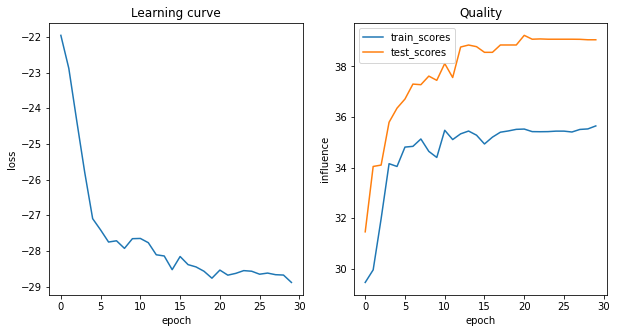

In [5]:

### main ###
train_scores = []
test_scores  = []
loss_f = []

def eval_grd(net, instances):
        return np.mean([set_func(greedy(k, net(data[i]).view_as(Ps[0]), w)[1], Ps[i], w) for i in instances])

test  = tests[0] 
train = trains[0]
dataset = torch.utils.data.TensorDataset(data[train], Ps[train])

net = make_fc(num_features, num_layers, activation, intermediate_size)
net.apply(init_weights)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
print("epoch | loss | train_score | test_score ")

for epoch in range(30):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
        
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            true_set_func = partial(set_func, P = P, w = w)
            marginal_vec_pred = partial(marginal_vec, w = w)
            pred = net(X).view_as(P)  
                            
            
            loss -= GreedyOptimizer.apply(pred, true_set_func, marginal_vec_pred, num_items, k, eps,sample_size, beta)
    
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_score = eval_grd(net, train)
    test_score  = eval_grd(net, test)
    loss_f.append(loss.item())
    
    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)
    
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(loss_f)
ax[0].set_title('Learning curve')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
#ax[0].set_ylim(1.1 * min(loss_f), 0)

ax[1].plot(train_scores, label="train_scores")
ax[1].plot(test_scores, label="test_scores")
ax[1].set_title('Quality')
ax[1].set_ylabel('influence')
ax[1].set_xlabel('epoch')
ax[1].legend()


epoch | loss | train_score | test_score 
0 | 0.035960789769887924 | 28.805562603473664 | 32.2615288734436
1 | 0.015843266621232033 | 29.10516208410263 | 31.900278186798097
2 | 0.006283225491642952 | 28.638447374105453 | 31.034129238128664
3 | 0.0022045967634767294 | 28.21382517814636 | 30.713952589035035
4 | 0.0007246900931932032 | 12.507984751462937 | 9.657602334022522
5 | 0.00042873562779277563 | 12.357725405693055 | 10.589367580413818
6 | 0.0004695923125836998 | 8.55221992433071 | 9.888981252908707
7 | 0.00047104497207328677 | 3.2077500194311144 | 7.081000232696534
8 | 0.00047105259727686644 | 3.2077500194311144 | 7.081000232696534
9 | 0.00047105259727686644 | 3.2077500194311144 | 7.081000232696534


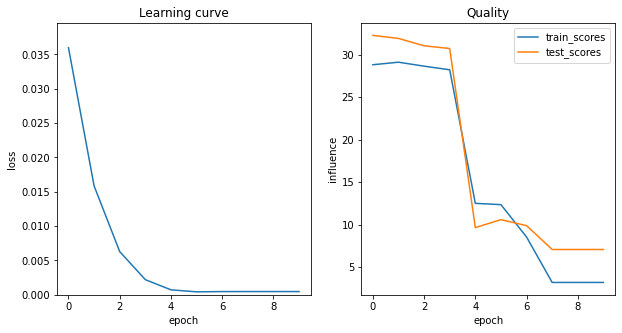

In [6]:
### main ###
train_scores = []
test_scores  = []
loss_2 = []

test  = tests[0] 
train = trains[0]
dataset = torch.utils.data.TensorDataset(data[train], Ps[train]) 
    
net = make_fc(num_features, num_layers, activation, intermediate_size)
net.apply(init_weights)
net = net.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

print("epoch | loss | train_score | test_score ")

for epoch in range(10):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X,P = X.to(device), P.to(device)

            pred = net(X).view_as(P)
            loss += loss_fn(pred, Ps[i])
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_score = eval_grd(net, train)
    test_score  = eval_grd(net, test)
    
    print(f"{epoch} | {loss} | {train_score} | {test_score}")    
    train_scores.append(train_score)
    test_scores.append(test_score)     
    loss_2.append(loss.item())

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(loss_2)
ax[0].set_title('Learning curve')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylim(0, 1.1 * max(loss_2))

ax[1].plot(train_scores, label="train_scores")
ax[1].plot(test_scores, label="test_scores")
ax[1].set_title('Quality')
ax[1].set_ylabel('influence')
ax[1].set_xlabel('epoch')
ax[1].legend()


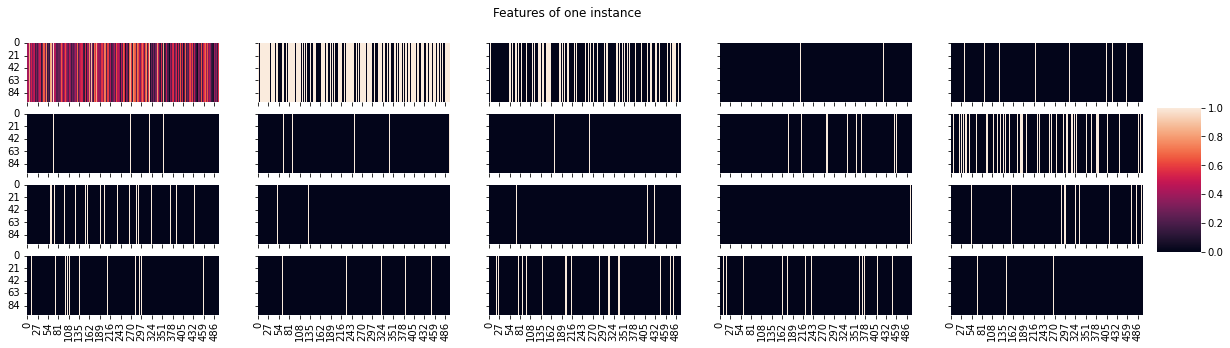

In [6]:
fig, axn = plt.subplots(4, 5, sharex=True, sharey=True, figsize = (20,5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    sns.heatmap((data[1,:,:,i] - data[1,:,:,i].min()) / (data[1,:,:,i].max() - data[1,:,:,i].min()), ax=ax,
                cbar=i == 0,                
                cbar_ax=None if i else cbar_ax)

plt.show()


IndexError: index 43 is out of bounds for dimension 3 with size 43

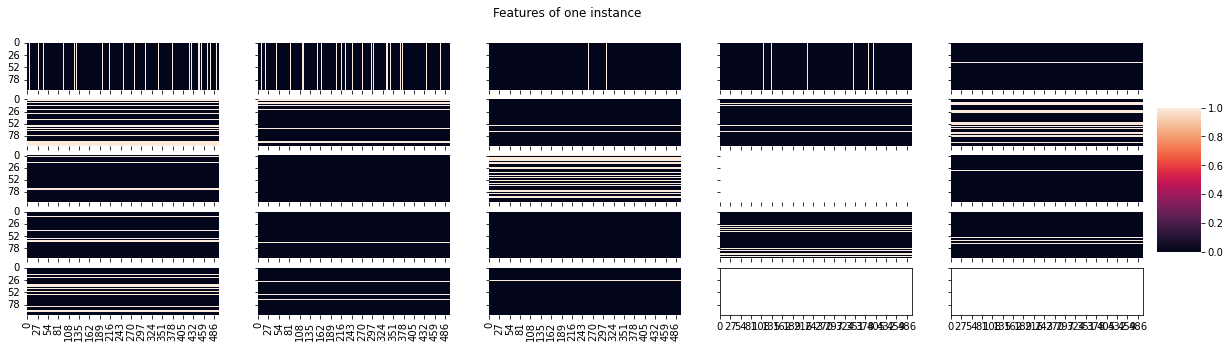

In [20]:

fig, axn = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    if i > 41 : break
    sns.heatmap((data[1,:,:,i+20] - data[1,:,:,i+20].min()) / (data[1,:,:,i+20].max() - data[1,:,:,i+20].min()), ax=ax,
                cbar=i == 0,
                cbar_ax=None if i else cbar_ax)


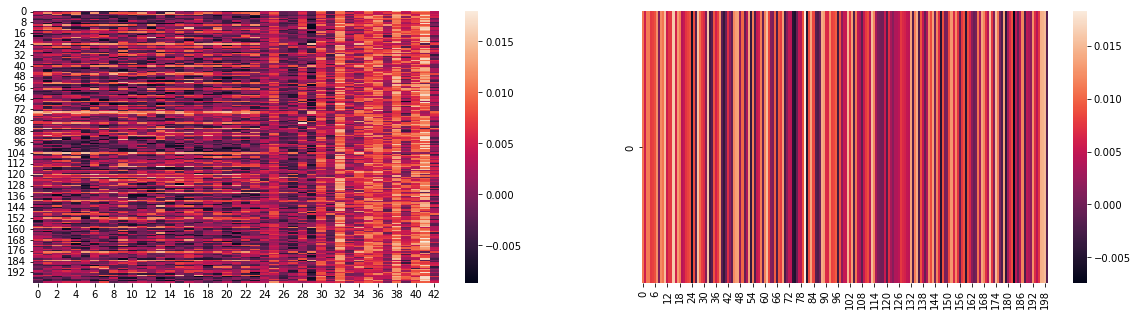

In [21]:
fig,ax = plt.subplots(max(num_layers // 5, 1) , num_layers, figsize = (20,5))

for i,ax in enumerate(ax.flat) :
    sns.heatmap(net[2*i].weight.detach().cpu().numpy(), ax=ax)
    

In [22]:
net.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=43, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
  (3): Hardtanh(min_val=0, max_val=1.0)
)>

end
